#Like Count Regression Task

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint

# Train Dataset Analysis

In [2]:
train_file_path = "/content/training-dataset.jsonl"

train_data = []
with open(train_file_path, "r", encoding="utf-8") as file:
    for line in file:
        try:
            json_object = json.loads(line.strip())
            train_data.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

df = pd.DataFrame(train_data)

# Flatten 'profile' to extract user-level data
profile_df = pd.json_normalize(df['profile'])

# Merge post-level and profile-level data
main_df = pd.concat([df.drop(columns=['profile']), profile_df], axis=1)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
main_df.head()


Error decoding JSON: Unterminated string starting at: line 1 column 67614 (char 67613)


,posts,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,bio_links,entities,ai_agent_type,fb_profile_biolink,restricted_by_viewer,country_block,eimu_id,external_url,fbid,has_clips,hide_like_and_view_counts,is_professional_account,is_supervision_enabled,is_guardian_of_viewer,is_supervised_by_viewer,is_supervised_user,is_embeds_disabled,is_joined_recently,business_address_json,business_contact_method,business_email,business_phone_number,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,[{'caption': 'Cumhuriyetimizin 100.yılı kutlu ...,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,NaN,1167,192,True,False,False,6,"""[{'title': '', 'lynx_url': 'https://l.instagr...",#mediaplanning #mediabuying #sosyalmedya,None,None,None,False,110133017051179,http://www.deparmedya.com/,17841403241896337,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",CALL,None,None,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,[{'caption': 'Bu diyaloğun yaşanmadığı bir onl...,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,NaN,1265,665,True,False,False,0,"""[{'title': '', 'lynx_url': 'https://l.instagr...",Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,None,None,None,False,109046377161056,http://yinemipazartesi.wordpress.com/,17841408443109307,False,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",UNKNOWN,None,None,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,[{'caption': 'Bugün bir fincan köpüklü Türk ka...,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,NaN,11997,17,True,False,False,15,"""[{'title': '', 'lynx_url': 'https://l.instagr...",📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,None,None,None,False,111783696881731,http://www.kafesfirin.com/,17841400227134163,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",CALL,None,None,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,[{'caption': 'Saygı ve özlemle🖤 #atatürk #10k...,vimerang,2367195567,Vimerang,Dijital İletişim Yönetimi🎬info@vimerang.comq,None,NaN,2321,454,True,False,False,11,"""[{'title': '', 'lynx_url': 'https://l.instagr...",Dijital İletişim Yönetimi🎬info@vimerang.comq,None,None,None,False,107818887285254,http://vimerang.com/,17841402267035899,True,True,True,False,False,False,False,False,False,"""{\""city_name\"": \""Istanbul, Turkey\"", \""city_...",CALL,None,None,Creators & Celebrities,None,VIDEO_CREATOR,False,False,https://instagram.fist19-1.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,[{'caption': 'Başöğretmenimiz Gazi Mustafa Kem...,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,NaN,28025,4,True,False,False,10,"""[{'title': '', 'lynx_url': 'https://l.instagr...",TotalEnergies İstasyonları resmi Instagram hes...,None,None,None,False,112204746839186,https://bit.ly/45XDUDr,17841407073803330,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",CALL,None,None,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [3]:
# Expand 'posts' list into separate rows
user_agg = main_df.explode('posts')

# Handle NaN posts
user_agg['posts'] = user_agg['posts'].apply(lambda x: x if isinstance(x, dict) else {})

# Extract 'like_count' and 'comments_count' from posts
user_agg['like_count'] = user_agg['posts'].apply(lambda x: x.get('like_count', 0))
user_agg['comments_count'] = user_agg['posts'].apply(lambda x: x.get('comments_count', 0))

# Aggregate at user level
user_avg = user_agg.groupby('username').agg({
    'follower_count': 'first',
    'following_count': 'first',
    'like_count': 'mean',  # Target
    'comments_count': 'mean',
    'category_enum': 'first',
    'is_business_account': 'first',
}).reset_index()


# Rename columns
user_avg.rename(columns={
    'like_count': 'average_like_count',
    'comments_count': 'average_comment_count'
}, inplace=True)

user_avg.head()


,username,follower_count,following_count,average_like_count,average_comment_count,category_enum,is_business_account
0,01burdaavm,34861,14,28.485714,1.200000,None,True
1,10burdaavm,35945,125,36.714286,0.171429,None,False
2,140journos,234739,0,13391.571429,135.657143,None,False
3,16roof,38555,6,75.142857,0.571429,RESTAURANT,True
4,16tarim,3079,1017,19.914286,0.171429,AGRICULTURAL_SERVICE,True


In [4]:
# Fill NaN for numerical columns in training data (user_avg)
user_avg.fillna({
    'follower_count': 0,
    'following_count': 0,
    'highlight_reel_count': 0,
    'average_comment_count': 0
}, inplace=True)

# Step 1: Drop rows where the target variable is missing or 0
user_avg = user_avg.dropna(subset=['average_like_count'])  # Drop if NaN
user_avg = user_avg[user_avg['average_like_count'] > 0]  # Drop if 0

# Remove rows with average_comment_count = 0
user_avg = user_avg[user_avg['average_comment_count'] > 0]

# Step 2: Replace None/NaN in category_enum with 'NONE' for training data
user_avg['category_enum'] = user_avg['category_enum'].astype(str)
user_avg['category_enum'].replace({None: 'NONE'}, inplace=True)
user_avg['category_enum'].fillna('NONE', inplace=True)  # Extra safeguard

# Step 3: Fit Label Encoder on the training data (excluding unnecessary columns)
label_encoder = LabelEncoder()
label_encoder.fit(user_avg['category_enum'])

# Step 4: Apply label encoding to the training data
user_avg['category_enum'] = label_encoder.transform(user_avg['category_enum'].astype(str))
user_avg['is_business_account'] = label_encoder.fit_transform(user_avg['is_business_account'].astype(str))

# Display the first few rows to verify changes
user_avg.head()


<ipython-input-4-a79f02f9332e>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_avg['category_enum'].replace({None: 'NONE'}, inplace=True)


,username,follower_count,following_count,average_like_count,average_comment_count,category_enum,is_business_account
0,01burdaavm,34861,14,28.485714,1.200000,214,1
1,10burdaavm,35945,125,36.714286,0.171429,214,0
2,140journos,234739,0,13391.571429,135.657143,214,0
3,16roof,38555,6,75.142857,0.571429,262,1
4,16tarim,3079,1017,19.914286,0.171429,6,1


In [5]:
user_avg.shape

(4129, 7)

In [6]:
# Drop non-numeric columns to calculate correlations
numerical_df = user_avg.drop(columns=['username'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Get the correlation of 'average_like_count' with all other features
correlation_with_likes = correlation_matrix['average_like_count']

# Display the correlations in descending order
print("Correlation with Average Like Count:\n")
print(correlation_with_likes.sort_values(ascending=False))


Correlation with Average Like Count:

average_like_count       1.000000
follower_count           0.745131
average_comment_count    0.233468
following_count          0.022287
category_enum           -0.001701
is_business_account     -0.143974
Name: average_like_count, dtype: float64


In [7]:
numerical_df.describe()

,follower_count,following_count,average_like_count,average_comment_count,category_enum,is_business_account
count,4.129000e+03,4129.000000,4.129000e+03,4129.000000,4129.000000,4129.000000
mean,2.571929e+05,510.522160,6.846384e+03,117.399752,201.852264,0.698474
std,2.037212e+06,1023.112959,5.037820e+04,1469.170896,76.170256,0.458976
min,1.800000e+01,0.000000,2.857143e-01,0.028571,0.000000,0.000000
25%,3.706000e+03,9.000000,3.151429e+01,0.542857,176.000000,0.000000
50%,1.482400e+04,80.000000,9.385714e+01,2.428571,214.000000,1.000000
75%,7.313400e+04,577.000000,5.421429e+02,17.971429,240.000000,1.000000
max,6.324671e+07,7533.000000,2.346595e+06,87147.466667,358.000000,1.000000


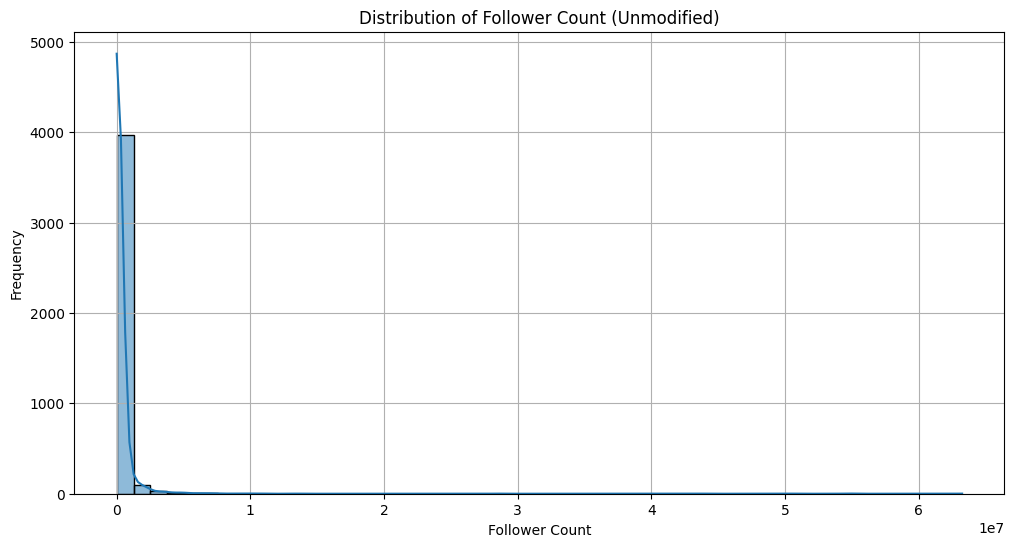

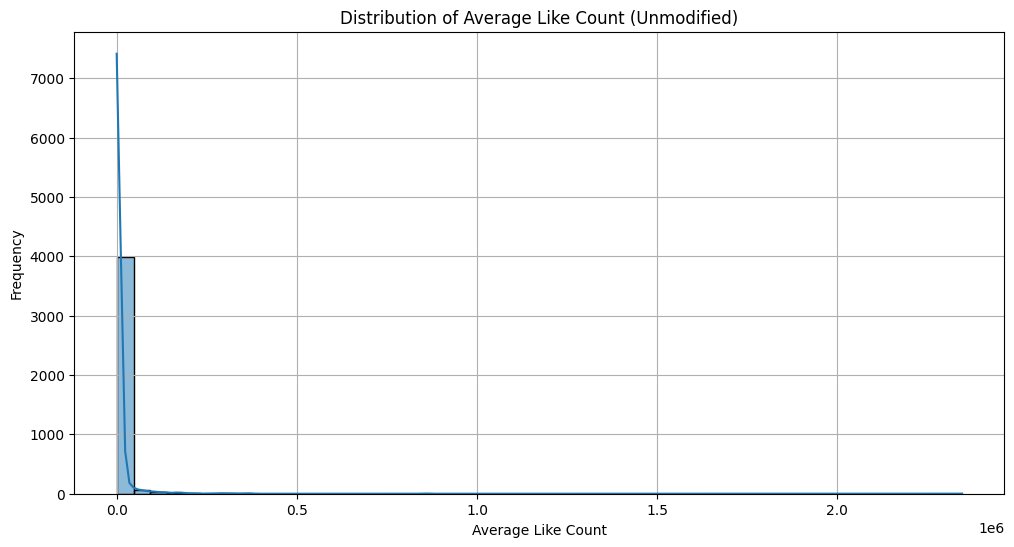

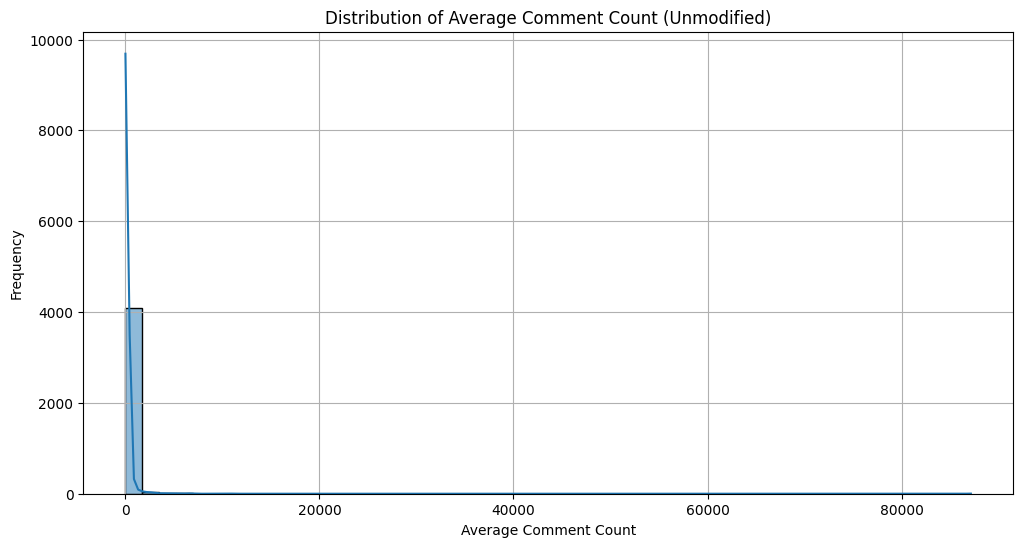

In [8]:

# ====== Visualize Follower Count Distribution ======
plt.figure(figsize=(12, 6))
sns.histplot(user_avg['follower_count'], bins=50, kde=True)
plt.title("Distribution of Follower Count (Unmodified)")
plt.xlabel("Follower Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ====== Visualize Average Like Count Distribution ======
plt.figure(figsize=(12, 6))
sns.histplot(user_avg['average_like_count'], bins=50, kde=True)
plt.title("Distribution of Average Like Count (Unmodified)")
plt.xlabel("Average Like Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ====== Visualize Average Comment Count Distribution ======
plt.figure(figsize=(12, 6))
sns.histplot(user_avg['average_comment_count'], bins=50, kde=True)
plt.title("Distribution of Average Comment Count (Unmodified)")
plt.xlabel("Average Comment Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [9]:
user_avg.describe()

,follower_count,following_count,average_like_count,average_comment_count,category_enum,is_business_account
count,4.129000e+03,4129.000000,4.129000e+03,4129.000000,4129.000000,4129.000000
mean,2.571929e+05,510.522160,6.846384e+03,117.399752,201.852264,0.698474
std,2.037212e+06,1023.112959,5.037820e+04,1469.170896,76.170256,0.458976
min,1.800000e+01,0.000000,2.857143e-01,0.028571,0.000000,0.000000
25%,3.706000e+03,9.000000,3.151429e+01,0.542857,176.000000,0.000000
50%,1.482400e+04,80.000000,9.385714e+01,2.428571,214.000000,1.000000
75%,7.313400e+04,577.000000,5.421429e+02,17.971429,240.000000,1.000000
max,6.324671e+07,7533.000000,2.346595e+06,87147.466667,358.000000,1.000000


In [10]:
def log_mse_like_counts(y_true, y_pred):
  """
  Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).

  Parameters:
  - y_true: array-like, actual like counts
  - y_pred: array-like, predicted like counts

  Returns:
  - log_mse: float, Log Mean Squared Error
  """
  # Ensure inputs are numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  # Compute squared errors
  squared_errors = (log_y_true - log_y_pred) ** 2

  # Return the mean of squared errors
  return np.mean(squared_errors)

# Test Dataset Analysis

In [11]:
test_file_path = "/content/test-regression-round1.jsonl"

test_data = []
with open(test_file_path, "r", encoding="utf-8") as file:
    for line in file:
        try:
            json_object = json.loads(line.strip())
            test_data.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

test_df = pd.DataFrame(test_data)
test_df.head()

,caption,comments_count,id,media_type,media_url,timestamp,username
0,"KOZA 2023 2.si Damla’nın koleksiyonu, Latinced...",2,18144550534306740,CAROUSEL_ALBUM,https://scontent-sof1-1.cdninstagram.com/v/t51...,2023-11-02 15:49:22,kozayarismasi
1,Tüm Türkiye ve Avrupa’ya sevkiyatlarımız aralı...,0,17995331788956693,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...,2023-08-19 13:46:02,celikbeymobilya
2,🤩\n\n.\n.\nDaha Fazlası İçin Beğenmeyi ve Taki...,75,18302703232191518,VIDEO,None,2023-10-02 06:53:33,girisimci_muhendis
3,En taze mezelerin en keyifli masalarda buluştu...,1,17908564031282979,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t51...,2022-01-31 12:02:05,levanteculina
4,Psikolojik güvenliği kısaca herhangi bir takım...,0,17952070292635946,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t51...,2023-06-30 08:46:05,acmagile


In [12]:
follower_threshold = user_avg['follower_count'].quantile(0.95)
like_threshold = user_avg['average_like_count'].quantile(0.95)
comment_threshold = user_avg['average_comment_count'].quantile(0.95)

print(f"Follower Threshold: {follower_threshold}")
print(f"Like Threshold: {like_threshold}")
print(f"Comment Threshold: {comment_threshold}")

Follower Threshold: 946794.6
Like Threshold: 24148.04571428569
Comment Threshold: 357.21714285714194


In [13]:
formatted_test_data = []

for i in test_df["username"]:
    if i in user_avg["username"].values:
        temp_row = user_avg.loc[user_avg["username"] == i]
        temp_row = temp_row.drop(columns=['average_like_count'])

        temp_row['id'] = test_df.loc[test_df["username"] == i]['id'].values[0]
        temp_row['username'] = test_df.loc[test_df["username"] == i]['username'].values[0]
        formatted_test_data.append(temp_row)

formatted_test_df = pd.concat(formatted_test_data, ignore_index=True)
formatted_test_df["average_like_count"] = 0  # Placeholder for prediction

print(formatted_test_df.shape)

# ====== Apply Outlier Criteria (Reindex to Test Data) ======
test_outlier_criteria = (
    (user_avg['follower_count'] > follower_threshold - 1) &
    (user_avg['average_like_count'] > like_threshold - 1) &
    (user_avg['average_comment_count'] > comment_threshold - 1)
)

# Reindex the boolean mask to align with formatted_test_df
test_outlier_criteria = test_outlier_criteria.reindex(formatted_test_df.index, fill_value=False)

# Split into Regular and Outlier Test Sets
test_outliers = formatted_test_df[test_outlier_criteria]
test_regular = formatted_test_df[~test_outlier_criteria]

test_regular['log_follower_count'] = np.log1p(test_regular['follower_count'])
test_regular['log_average_comment_count'] = np.log1p(test_regular['average_comment_count'])

test_outliers['log_follower_count'] = np.log1p(test_outliers['follower_count'])
test_outliers['log_average_comment_count'] = np.log1p(test_outliers['average_comment_count'])

# ====== Print Results ======
print(f"Total Test Samples: {formatted_test_df.shape[0]}")
print(f"Regular Test Samples: {test_regular.shape[0]}")
print(f"Outlier Test Samples: {test_outliers.shape[0]}")

# Display some samples
display(test_regular.head())
display(test_outliers.head())


(2304, 8)
Total Test Samples: 2304
Regular Test Samples: 2254
Outlier Test Samples: 50


<ipython-input-13-765511adef5f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_regular['log_follower_count'] = np.log1p(test_regular['follower_count'])
<ipython-input-13-765511adef5f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_regular['log_average_comment_count'] = np.log1p(test_regular['average_comment_count'])
<ipython-input-13-765511adef5f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,username,follower_count,following_count,average_comment_count,category_enum,is_business_account,id,average_like_count,log_follower_count,log_average_comment_count
0,kozayarismasi,8850,300,2.228571,214,0,18144550534306740,0,9.088286,1.172040
1,celikbeymobilya,65149,1,55.057143,140,1,17995331788956693,0,11.084448,4.026372
2,acmagile,1538,164,0.028571,307,1,17952070292635946,0,7.338888,0.028171
3,birfilmbirsanat,26772,142,3.314286,214,0,18006505006830927,0,10.195149,1.461932
4,turkiyemsdernegi,13526,32,12.257143,212,1,18286262458117950,0,9.512443,2.584536


,username,follower_count,following_count,average_comment_count,category_enum,is_business_account,id,average_like_count,log_follower_count,log_average_comment_count
29,medipolsaglik,110565,5,1.085714,161,1,17890860047927323,0,11.613368,0.735111
31,haribochamallows,10133,4,0.657143,133,1,17945590397091132,0,9.223651,0.505095
40,orenciftligi,4491,79,5.942857,214,1,17926097765109780,0,8.410053,1.937713
60,vodafonetr,239510,9,175.485714,296,1,18307230748117583,0,12.386355,5.173240
175,nouva_art,7549,520,0.228571,209,1,17978133395541948,0,8.929303,0.205852


# Train the Training Dataset

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# ====== Apply Log Transformation to Key Features ======
user_avg['log_follower_count'] = np.log1p(user_avg['follower_count'])
user_avg['log_average_comment_count'] = np.log1p(user_avg['average_comment_count'])

# ====== Define Outliers (High-Engagement Accounts) ======
outlier_criteria = (
    (user_avg['follower_count'] > follower_threshold - 1) &
    (user_avg['average_like_count'] > like_threshold - 1) &
    (user_avg['average_comment_count'] > comment_threshold - 1)
)

outliers = user_avg[outlier_criteria]
regular_data = user_avg[~outlier_criteria]

# ====== Split Features and Target ======
X_regular = regular_data.drop(columns=['username', 'average_like_count', 'follower_count', 'average_comment_count'])
y_regular = regular_data['average_like_count']

X_outliers = outliers.drop(columns=['username', 'average_like_count', 'follower_count', 'average_comment_count'])
y_outliers = outliers['average_like_count']

# ====== Log Transform Target for Regular and Outliers ======
y_regular_log = np.log1p(y_regular)  # Log transform for regular data
y_outliers_log = np.log1p(y_outliers)  # Log transform for outliers

# ====== Train-Validation Split (85% Train, 15% Validation) ======
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_regular, y_regular_log, test_size=0.15, random_state=42)

X_train_out, X_val_out, y_train_out, y_val_out = train_test_split(X_outliers, y_outliers_log, test_size=0.15, random_state=42)

# ====== Train Models ======
# Random Forest for Regular Data (Log Target)
rf_regular = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
rf_regular.fit(X_train_reg, y_train_reg)

# Ridge Regression for Outliers (Log Target)
ridge_outliers = Ridge(alpha=1.0)
ridge_outliers.fit(X_train_out, y_train_out)

# ====== Predict and Evaluate ======
# Regular Data Predictions (Log Inverse Transformation)
y_pred_train_reg_log = rf_regular.predict(X_train_reg)
y_pred_val_reg_log = rf_regular.predict(X_val_reg)

y_pred_train_reg = np.expm1(y_pred_train_reg_log)
y_pred_val_reg = np.expm1(y_pred_val_reg_log)

y_train_reg_actual = np.expm1(y_train_reg)  # Inverse transform actuals
y_val_reg_actual = np.expm1(y_val_reg)

# Outlier Predictions (Log Inverse Transformation)
y_pred_train_out_log = ridge_outliers.predict(X_train_out)
y_pred_val_out_log = ridge_outliers.predict(X_val_out)

y_pred_train_out = np.expm1(y_pred_train_out_log)
y_pred_val_out = np.expm1(y_pred_val_out_log)

y_train_out_actual = np.expm1(y_train_out)
y_val_out_actual = np.expm1(y_val_out)

# ====== Cap Negative Predictions at 0 ======
y_pred_train_reg = np.maximum(y_pred_train_reg, 0)
y_pred_val_reg = np.maximum(y_pred_val_reg, 0)

y_pred_train_out = np.maximum(y_pred_train_out, 0)
y_pred_val_out = np.maximum(y_pred_val_out, 0)

# ====== Calculate Log MSE ======
log_mse_train_reg = log_mse_like_counts(y_train_reg_actual, y_pred_train_reg)
log_mse_val_reg = log_mse_like_counts(y_val_reg_actual, y_pred_val_reg)

log_mse_train_out = log_mse_like_counts(y_train_out_actual, y_pred_train_out)
log_mse_val_out = log_mse_like_counts(y_val_out_actual, y_pred_val_out)

# ====== Print Results ======
print("Regular Data (Non-Outliers - Random Forest with Log Target):")
print(f"Log MSE - Train: {log_mse_train_reg:.4f}")
print(f"Log MSE - Validation: {log_mse_val_reg:.4f}")

print("\nHigh Engagement Outliers (Ridge Regression - Log Target):")
print(f"Log MSE - Train: {log_mse_train_out:.4f}")
print(f"Log MSE - Validation: {log_mse_val_out:.4f}")


Regular Data (Non-Outliers - Random Forest with Log Target):
Log MSE - Train: 0.3164
Log MSE - Validation: 0.8076

High Engagement Outliers (Ridge Regression - Log Target):
Log MSE - Train: 0.3548
Log MSE - Validation: 0.2838


In [15]:
user_avg.head()

,username,follower_count,following_count,average_like_count,average_comment_count,category_enum,is_business_account,log_follower_count,log_average_comment_count
0,01burdaavm,34861,14,28.485714,1.200000,214,1,10.459153,0.788457
1,10burdaavm,35945,125,36.714286,0.171429,214,0,10.489773,0.158224
2,140journos,234739,0,13391.571429,135.657143,214,0,12.366234,4.917475
3,16roof,38555,6,75.142857,0.571429,262,1,10.559867,0.451985
4,16tarim,3079,1017,19.914286,0.171429,6,1,8.032685,0.158224


# Test Data Prediction

In [16]:
# ====== Predict Regular Test Data ======
test_df_usernames_reg = test_regular['username']
test_df_ids_reg = test_regular['id']
test_regular = test_regular.drop(columns=['username', 'average_like_count', 'id', 'average_comment_count', 'follower_count'])

predicted_likes_reg = rf_regular.predict(test_regular)
predicted_likes_reg = np.maximum(predicted_likes_reg, 0)  # Ensure no negative predictions
predicted_likes_reg = np.expm1(predicted_likes_reg)  # Inverse log transformation

# ====== Predict Outlier Test Data ======
test_df_usernames_out = test_outliers['username']
test_df_ids_out = test_outliers['id']
test_outliers = test_outliers.drop(columns=['username', 'average_like_count', 'id', 'average_comment_count', 'follower_count'])

predicted_likes_out = ridge_outliers.predict(test_outliers)
predicted_likes_out = np.maximum(predicted_likes_out, 0)  # Ensure no negative predictions
predicted_likes_out = np.expm1(predicted_likes_out)  # Inverse log transformation

# ====== Combine Predictions ======
output_list = []
output_path = "/content/prediction-regression-round1.json"

# Regular Data Output
for i in range(len(test_df_ids_reg)):
    temp = dict()
    temp[test_df_ids_reg.iloc[i]] = predicted_likes_reg[i]
    output_list.append(temp)

# Outlier Data Output
for i in range(len(test_df_ids_out)):
    temp = dict()
    temp[test_df_ids_out.iloc[i]] = predicted_likes_out[i]
    output_list.append(temp)

# ====== Save to JSONL ======
with open(output_path, "wt") as of:
    json.dump(output_list, of)

print("Predictions saved successfully!")


Predictions saved successfully!


In [17]:
pprint(output_list)

[{'18144550534306740': 105.2113039281823},
 {'17995331788956693': 281.67290962950443},
 {'17952070292635946': 13.803671843358124},
 {'18006505006830927': 197.8858010813224},
 {'18286262458117950': 227.76790230706234},
 {'17978285044655063': 47.51340324716616},
 {'17979705191281621': 91.66480736431647},
 {'17943151460632003': 327.97908345110227},
 {'17861492289039898': 40.054481781040536},
 {'17944152709667359': 10.95881021752729},
 {'17946532007722888': 116.28830711558376},
 {'18028019713726588': 45.15817759688059},
 {'17892354218074539': 486.96153720777255},
 {'17980987190325188': 4054.7742503420127},
 {'17991284126166986': 90.21591837658143},
 {'17944813924843982': 13.106588682605071},
 {'17952026065796308': 25.49684321916626},
 {'18004974424862315': 218.39247791620951},
 {'18392577763038708': 3421.479929738399},
 {'18138147664306672': 175.87465809303745},
 {'17940570425311842': 65.59757421717187},
 {'18199557373285197': 52.99649025366138},
 {'17995058891352723': 334.97570508755865},